In [5]:
if __name__ is '__main__':
    from notebookism import env, iframe, refs, toggler, get_
else:
    from .utils import env, iframe, refs
    from .currents import get_
    
from toolz.curried import *
from whatever import *
import pandas, requests, ujson
from IPython import display, get_ipython
toggler()

<IPython.core.display.Javascript object>


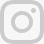

In [6]:
%%display HTML _
<h1>Pulp-free notebooks</h1>

<blockquote class="instagram-media" data-instgrm-captioned data-instgrm-version="7" style=" background:#FFF; border:0; border-radius:3px; box-shadow:0 0 1px 0 rgba(0,0,0,0.5),0 1px 10px 0 rgba(0,0,0,0.15); margin: 1px; max-width:658px; padding:0; width:99.375%; width:-webkit-calc(100% - 2px); width:calc(100% - 2px);"><div style="padding:8px;"> <div style=" background:#F8F8F8; line-height:0; margin-top:40px; padding:50.0% 0; text-align:center; width:100%;"> <div style=" background:url(data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAACwAAAAsCAMAAAApWqozAAAABGdBTUEAALGPC/xhBQAAAAFzUkdCAK7OHOkAAAAMUExURczMzPf399fX1+bm5mzY9AMAAADiSURBVDjLvZXbEsMgCES5/P8/t9FuRVCRmU73JWlzosgSIIZURCjo/ad+EQJJB4Hv8BFt+IDpQoCx1wjOSBFhh2XssxEIYn3ulI/6MNReE07UIWJEv8UEOWDS88LY97kqyTliJKKtuYBbruAyVh5wOHiXmpi5we58Ek028czwyuQdLKPG1Bkb4NnM+VeAnfHqn1k4+GPT6uGQcvu2h2OVuIf/gWUFyy8OWEpdyZSa3aVCqpVoVvzZZ2VTnn2wU8qzVjDDetO90GSy9mVLqtgYSy231MxrY6I2gGqjrTY0L8fxCxfCBbhWrsYYAAAAAElFTkSuQmCC); display:block; height:44px; margin:0 auto -44px; position:relative; top:-22px; width:44px;"></div></div> <p style=" margin:8px 0 0 0; padding:0 4px;"> <a href="https://www.instagram.com/p/BLB2VL7hjxG/" style=" color:#000; font-family:Arial,sans-serif; font-size:14px; font-style:normal; font-weight:normal; line-height:17px; text-decoration:none; word-wrap:break-word;" target="_blank">Notebookism #calligraphy #fabriano</a></p> <p style=" color:#c9c8cd; font-family:Arial,sans-serif; font-size:14px; line-height:17px; margin-bottom:0; margin-top:8px; overflow:hidden; padding:8px 0 7px; text-align:center; text-overflow:ellipsis; white-space:nowrap;">A video posted by Tony Fast (@docfast) on <time style=" font-family:Arial,sans-serif; font-size:14px; line-height:17px;" datetime="2016-10-01T17:35:34+00:00">Oct 1, 2016 at 10:35am PDT</time></p></div></blockquote>
<script async defer src="//platform.instagram.com/en_US/embeds.js"></script>

# Who am I?

* I am a scientist.  
* I work at Continuum Analytics.
* I am trained as a materials scientist with a focus on collaborative research.
* I am not a developer.

# Why am I giving this talk?

I've made a lot of notebooks.  As a scientist, they feel right.

[Twitter](https://twitter.com/docfast)/[Instagram](https://instagram.com/docfast) - @docfast

[Github](https://github.com/tonyfast) - @tonyfast

In [7]:
import ujson
def read_json(fn):
    with open('../../'+fn, 'r') as f:
        data = ujson.load(f)
    return data

# Find all my notebooks
__notebooks = (__x('http://localhost:8888/api/contents')
 | requests.get | _this().json()['content']._
) + __x().get('type').eq('notebook').__ 


In [8]:
# Compose a function to read all of the notebooks
__contents =  __notebooks | pluck('name') | list | map(read_json) | list

# Clean up the notebooks to extract my imports
__notebook_imports = (
    __x(__contents.copy().pluck('cells').first.__()) 
    + _this()['cell_type'].copy().eq('code')._ 
    | pluck('source') 
    | concat 
    | '\n'.join 
    | (lambda x: x.split(';')) 
    | map(lambda x: first(x.split('#',1)))
    | '\n'.join
    | str.splitlines
)

__notebook_imports = __notebook_imports * str.lstrip + (
    lambda x: x.startswith('from ') or x.startswith('import ')
) 

__notebook_imports = (
    __notebook_imports 
    * (lambda x: second(x.split(' ',1)))  * (lambda x: first(x.split(' import',1)))
    * (lambda x: first(x.split(' as',1))) * (lambda x: x.split(','))
).concat * (lambda x: first(x.split('.',1))) | unique

__notebook_imports = __notebook_imports * str.strip | list

contents = __contents.copy().pluck('cells').list.__()

In [9]:
# Compose a dataframe of all of my imports
imports = __x(contents).map(
    __notebook_imports.__
).zip(
    __notebooks * (
        _this()['created']._, _this()['name']._
    ) > identity
).dict.valmap(
    __x() * [identity, lambda x: 1] | dict > compose
) | pandas.DataFrame > _this().fillna(0).transpose()._

imports = imports.set_index(
    imports.index.set_levels(
        pandas.to_datetime(imports.index.get_level_values(0)),
        level=0
    )
)
imports = imports.groupby([
    imports.index.get_level_values(0).year, 
    imports.index.get_level_values(0).month//3, 
]).sum().transpose().sort_values((2016,2,), ascending=False)
pass

In [10]:
%%display HTML _
<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">Hit a milestone! 💯+💯 Untitled <a href="https://twitter.com/ProjectJupyter">@ProjectJupyter</a> notebooks, over 600 total. What did I import? <a href="https://t.co/uyYA04eS4H">https://t.co/uyYA04eS4H</a> <a href="https://t.co/wWhALjxM6x">pic.twitter.com/wWhALjxM6x</a></p>&mdash; Tony Fast (@DocFast) <a href="https://twitter.com/DocFast/status/761955669293600768">August 6, 2016</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>

In [11]:
%%display Markdown _
[Apparently, I've made enough notebooks to break nbviewer]({{refs['broke']}})

[Apparently, I've made enough notebooks to break nbviewer](https://github.com/jupyter/nbviewer/issues/631)

In [12]:
imports.head(15)

2015        2016                  
                3     4     0     1     2     3
pandas        5.0   5.0  34.0  39.0  67.0  18.0
toolz         0.0   0.0   1.0   7.0  62.0  25.0
bokeh        20.0   8.0  23.0  28.0  43.0   5.0
sklearn       1.0   0.0   1.0   1.0  40.0  11.0
jinja2        8.0  11.0  24.0  26.0  30.0   5.0
whatever4e    0.0   0.0   0.0   0.0  29.0   0.0
IPython      10.0  11.0  34.0  30.0  28.0   8.0
whatever      0.0   0.0   0.0   0.0  28.0  29.0
requests      3.0   3.0  18.0  26.0  20.0   8.0
coffeetools   8.0   9.0  12.0  24.0  17.0   1.0
inspect       0.0   0.0   3.0   2.0  14.0   4.0
dask          0.0   0.0   1.0   6.0  11.0   4.0
ipywidgets    0.0   0.0  22.0  29.0  11.0   2.0
time          0.0   0.0   0.0   3.0  11.0   3.0
jinjamagic    0.0   0.0   0.0   9.0  11.0   0.0

In [8]:
%%display HTML _
<iframe src="//www.slideshare.net/slideshow/embed_code/key/yn5hJPTh6WTqeC?startSlide=13" width="595" height="485" frameborder="0" marginwidth="0" marginheight="0" scrolling="no" style="border:1px solid #CCC; border-width:1px; margin-bottom:5px; max-width: 100%;" allowfullscreen> </iframe> <div style="margin-bottom:5px"> <strong> <a href="//www.slideshare.net/tonyfast1/the-internet-killed-the-lab-notebook" title="The internet killed the lab notebook" target="_blank">The internet killed the lab notebook</a> </strong> from <strong><a href="//www.slideshare.net/tonyfast1" target="_blank">Tony Fast</a></strong> </div>

In [9]:
__x('basquiat') | refs.__getitem__ > iframe

In [10]:
__x('odsc_rise') | refs.__getitem__ > iframe

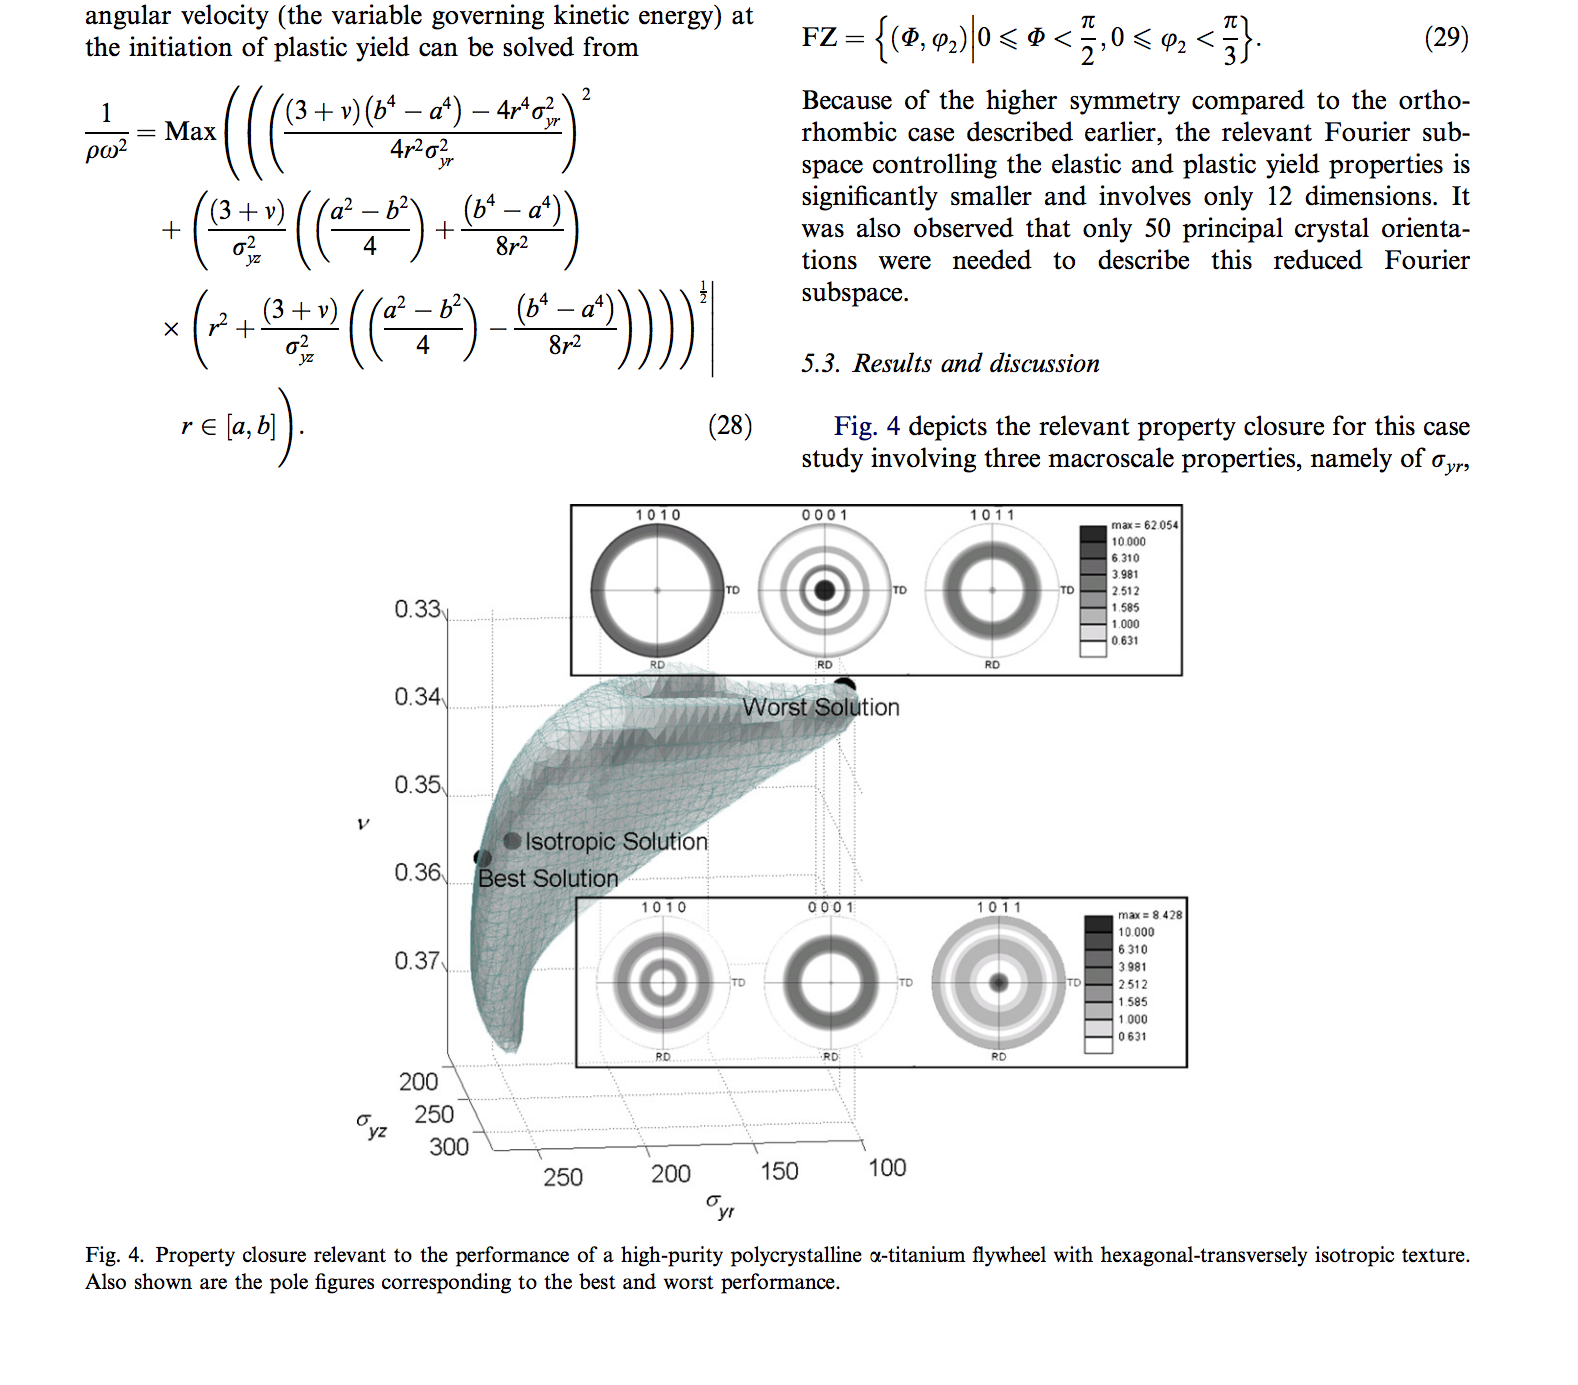

In [11]:
display.Image('../../emojis/hull.png', embed=True)

In [2]:
%%display Markdown _

# Notebooks

0. Maple
0. [Sage]({{refs['sage']}}) 
0. [IPython]({{refs['ipython']}}) - file system agnostic. 
0. [Ju~~lia~~Pyt~~hon~~*e*R]({{refs['jupyter']}}) - kernel agnostic
0. [Beaker]({{refs['beaker']}}) 
0. [Rodeo]({{refs['beaker']}}) - An IDE for data science
0. [Zeppelin]({{refs['beaker']}}) - For the Java Folks
0. [JupyterLab]({{refs['lab']}}) - `conda install -c conda-forge jupyterlab`
0. [nteract]({{refs['nteract']}}) - A desktop application for notebook built on electron

In [12]:
# A notebook history by the man who made it.
iframe(refs['fp_history'])

In [13]:
%%display Markdown _

## [Key Design Features <small>`2012`</small>]({{refs['fp_history']}})

Excerpts from "The IPython notebook: a historical retrospective".

* the natural flow of scientific computing pretty much mandates a solid interactive environment

* cleaner parallel computing, multiprocess clients and a notebook. 

* We deliberately chose a structured JSON format for our documents. It's clear enough for human reading while allowing easy and powerful machine manipulation without having to write our own parsing.  So writing utilities like a reStructuredText or LaTeX converter is very easy, as we recently showed.

* Because our notebook works in the normal filesystem, and lets you create .py files right 
next to the .ipynb just by passing --script at startup, you can reuse your notebooks like normal scripts, import one notebook from another or a normal python script, etc.

## [Currently... <small>`2016`</small>]({{refs['bloomberg']}})

> “What we’re seeing is that by lowering that barrier and by producing a tool that is very close to the natural workflow, it makes it sort of easy to do the right thing,” says Fernando Perez, a research scientist at UC Berkeley and one of the founders of the Berkeley Institute for Data Science.


## [Key Design Features <small>`2012`</small>](http://blog.fperez.org/2012/01/ipython-notebook-historical.html)

Excerpts from "The IPython notebook: a historical retrospective".

* the natural flow of scientific computing pretty much mandates a solid interactive environment

* cleaner parallel computing, multiprocess clients and a notebook. 

* We deliberately chose a structured JSON format for our documents. It's clear enough for human reading while allowing easy and powerful machine manipulation without having to write our own parsing.  So writing utilities like a reStructuredText or LaTeX converter is very easy, as we recently showed.

* Because our notebook works in the normal filesystem, and lets you create .py files right 
next to the .ipynb just by passing --script at startup, you can reuse your notebooks like normal scripts, import one notebook from another or a normal python script, etc.

## [Currently... <small>`2016`</small>](https://www.techatbloomberg.com/blog/inside-the-collaboration-that-built-the-open-source-jupyterlab-project/)

> “What we’re seeing is that by lowering that barrier and by producing a tool that is very close to the natural workflow, it makes it sort of easy to do the right thing,” says Fernando Perez, a research scientist at UC Berkeley and one of the founders of the Berkeley Institute for Data Science.

In [14]:
%%display Markdown _
![](https://upload.wikimedia.org/wikipedia/commons/4/48/Data_driven_journalism_process.jpg)

# Themes in Data Driven Journalism

* Technology driven shifts
* Access to information - _open source, open data, open journals.._
* Trust of information

> [Original notebook]({{refs['tf_journalism']}})

![](https://upload.wikimedia.org/wikipedia/commons/4/48/Data_driven_journalism_process.jpg)

# Themes in Data Driven Journalism

* Technology driven shifts
* Access to information - _open source, open data, open journals.._
* Trust of information

> [Original notebook](https://anaconda.org/tonyfast/what-can-we-learn-from-journalism/notebook)

In [15]:
%%display Markdown _

# [Elements of Journalism]({{refs['eoj']}})

##### <span style="color: red;">Journalism’s first obligation is to the truth</span>
##### Its first loyalty is to citizens
##### <span style="color: red;">Its essence is a discipline of verification</span>
##### Its practitioners must maintain an independence from those they cover
##### It must serve as an independent monitor of power
##### It must provide a forum for public criticism and compromise
#####  It must strive to keep the significant interesting and relevant
#####  It must keep the news comprehensive and proportional
#####  Its practitioners must be allowed to exercise their personal conscience
#####  Citizens, too, have rights and responsibilities when it comes to the news


# [Elements of Journalism](https://www.americanpressinstitute.org/journalism-essentials/what-is-journalism/elements-journalism/)

##### <span style="color: red;">Journalism’s first obligation is to the truth</span>
##### Its first loyalty is to citizens
##### <span style="color: red;">Its essence is a discipline of verification</span>
##### Its practitioners must maintain an independence from those they cover
##### It must serve as an independent monitor of power
##### It must provide a forum for public criticism and compromise
#####  It must strive to keep the significant interesting and relevant
#####  It must keep the news comprehensive and proportional
#####  Its practitioners must be allowed to exercise their personal conscience
#####  Citizens, too, have rights and responsibilities when it comes to the news

---

###### Journalism’s first obligation is to the truth

> > ## “All truths – even the laws of science – are subject to revision, but we operate by them in the meantime because they are necessary and they work,” 
    
    > ### “the truths by which we can operate on a day-to-day basis.”
    
---    

---
###### Its essence is a discipline of verification

> ### Being impartial or neutral is not a core principal of journalism. Because the journalist must make decisions, he or she is not and cannot be objective. 

> ## But journalistic methods are objective.

---